# Lendo os dados e importando as libs 

In [3]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

In [4]:
data = pd.read_csv('df.csv')

In [5]:
data.head()

,Time,D-GLOBO
0,1998-02-11,1540
1,1998-02-12,1510
2,1998-02-13,1480
3,1998-02-14,1490
4,1998-02-15,1480


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Time     234 non-null    object
 1   D-GLOBO  234 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


# Pré processamento

In [7]:
data['Time'] =  pd.to_datetime(data['Time'], format='%Y-%m-%d') #transformando em datetime 

In [8]:
data = data.set_index('Time') #transformando em DatetimeIndex 

In [9]:
data.tail()

,D-GLOBO
Time,
1998-09-28,1170
1998-09-29,1170
1998-09-30,1170
1998-10-01,1170
1998-10-02,1170


In [10]:
def plotar(title, labelx, labely, x, y, dataset):
  ax = sns.lineplot(x = x, y = y, data = dataset)
  ax.figure.set_size_inches(12,8)
  ax.set_title(title, loc = 'left', fontsize = 18)
  ax.set_xlabel(labelx, fontsize = 14)
  ax.set_ylabel(labely, fontsize = 14);

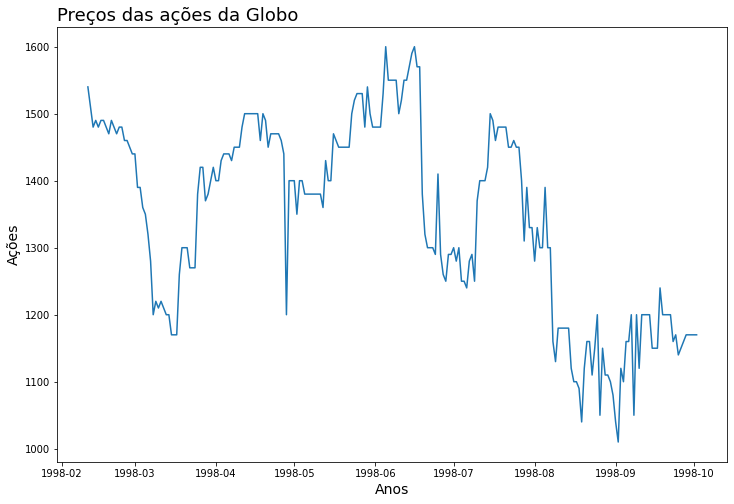

In [11]:
plotar('Preços das ações da Globo','Anos','Ações',data.index,
       'D-GLOBO',data)

a série não apresenta sazonalidade clara e com tendência aleatório de descrescimento aparentemente. Será feito testes formais para considerar a série como estacionária.

In [12]:
comeco_train = '1998-02-11'
termino_train = '1998-08-15'
comeco_test = '1998-08-16'
termino_test = '1998-10-02'

df_train = data[comeco_train:termino_train]
df_test = data[comeco_test:termino_test]
df_train.shape, df_test.shape

((186, 1), (48, 1))

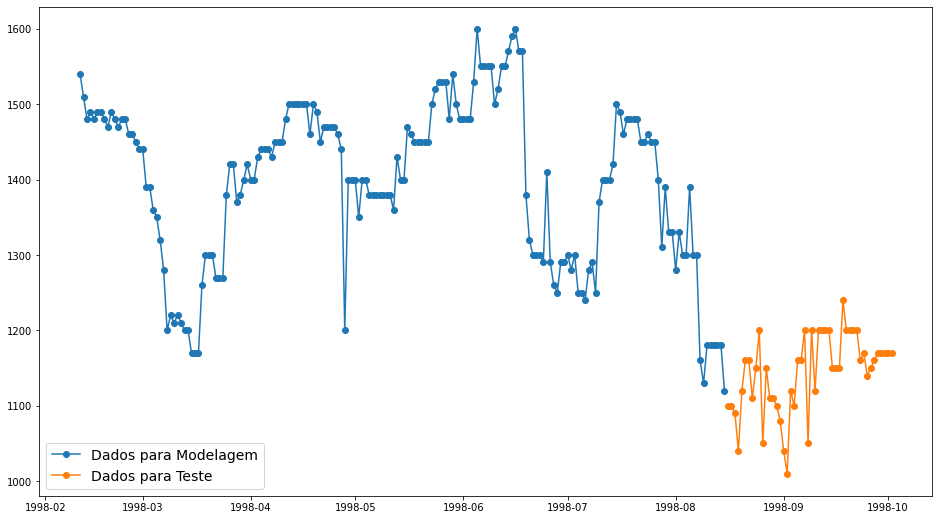

In [13]:
plt.figure(figsize = (16, 9))

plt.plot(df_train['D-GLOBO'], 'o-')
plt.plot(df_test['D-GLOBO'], 'o-')

legenda = ('Dados para Modelagem', 'Dados para Teste')
plt.legend(legenda, loc = 'lower left', prop = {'size': 14})


# Identificação de modelos candidatos

###Checar estacionariedade dos dados

In [14]:
def media_movel(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    plt.figure(figsize = (12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='média móvel')
    std = plt.plot(rolstd, color='black', label = 'desvio padrão')
    plt.legend(loc='best')
    plt.title('média móvel e desvio padrão')
    plt.show(block=False)


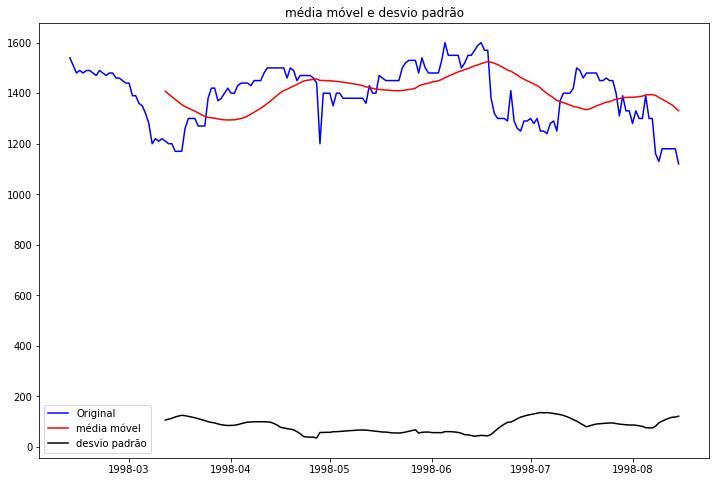

In [15]:
media_movel(df_train)

In [16]:
resultado = sm.tsa.adfuller(df_train['D-GLOBO'])
print('p-value: {}'.format(resultado[1]))

p-value: 0.35023316849123143


como o p-value é 0.286, temos evidências o suficiente para dizer que a série não é estacionária, para tanto, será feito o log da série fazendo a diferenciação no intuito de que a série passe a ser estacionária 

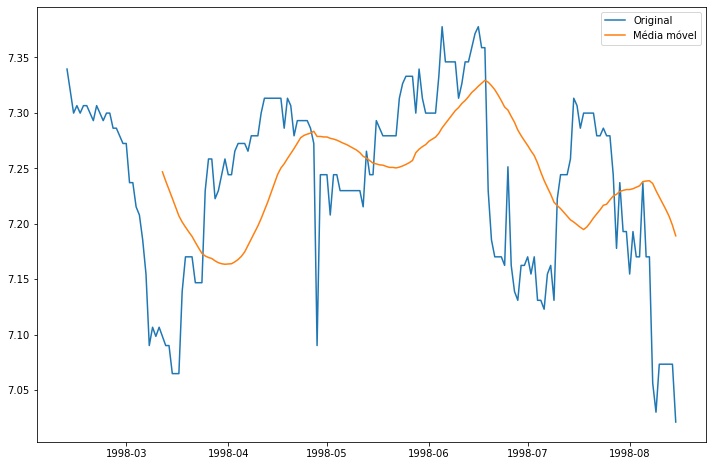

In [17]:
ts_log = np.log(df_train)
moving_avg = ts_log.rolling(30).mean()

plt.figure(figsize = (12, 8))
plt.plot(ts_log, label='Original')
plt.plot(moving_avg, label='Média móvel')
plt.legend(loc='best')


###decompondo os dados

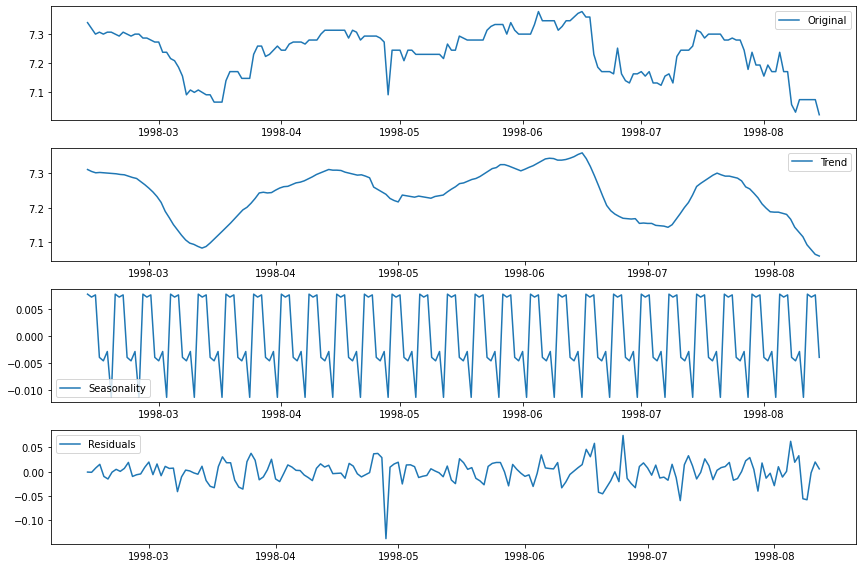

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (12, 8))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

###transformando os dados

In [19]:
ts_log_moving_avg_diff = ts_log - moving_avg
serie = ts_log_moving_avg_diff.diff()

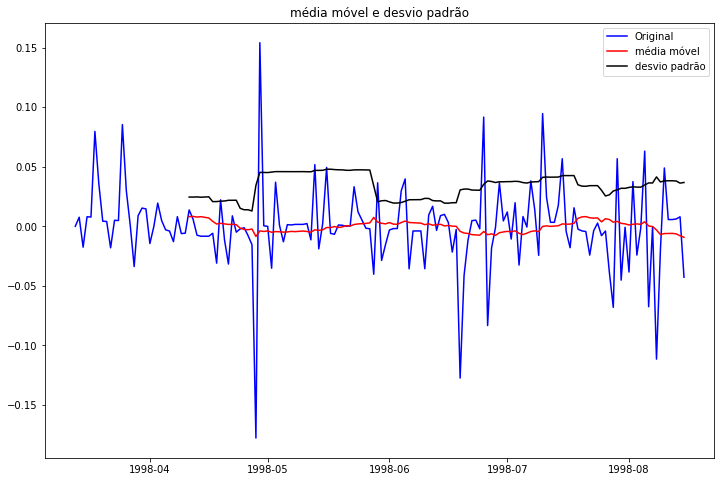

In [20]:
media_movel(serie)


###teste adfuller

In [21]:
resultado = sm.tsa.adfuller(serie['D-GLOBO'].dropna())
print('p-value: {}'.format(resultado[1]))

p-value: 3.6885040860683494e-27


In [22]:
print(f'Resultado: A série temporal é {"não " if resultado[1] > 0.05 else ""}estacionária.')


Resultado: A série temporal é estacionária.


##Definição de P, D e Q

D é o número de difereniações feita, e como visto anteriormente, para este estudo foi feito 2 diferenciações.


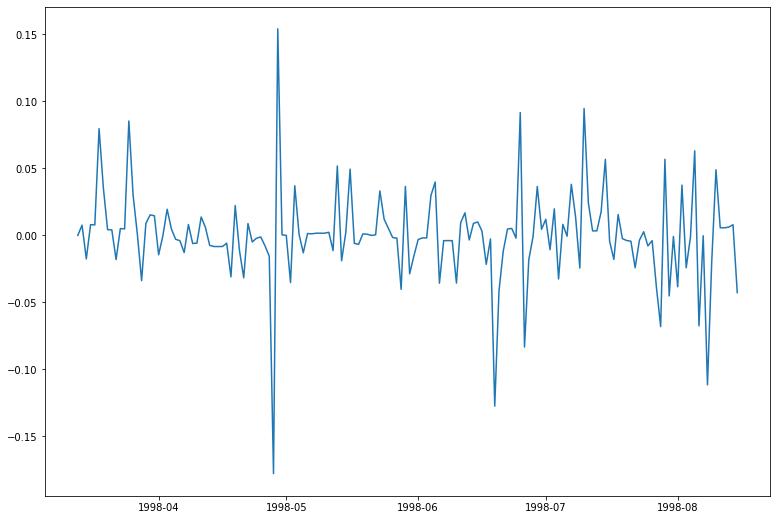

In [23]:
plt.figure(figsize = (13, 9))
plt.plot(serie)

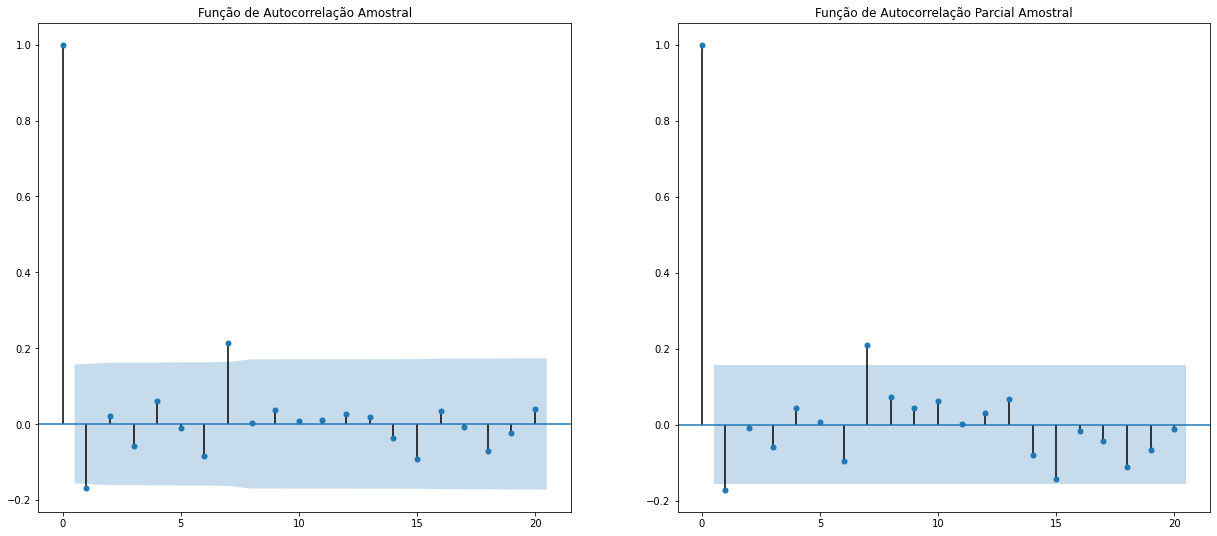

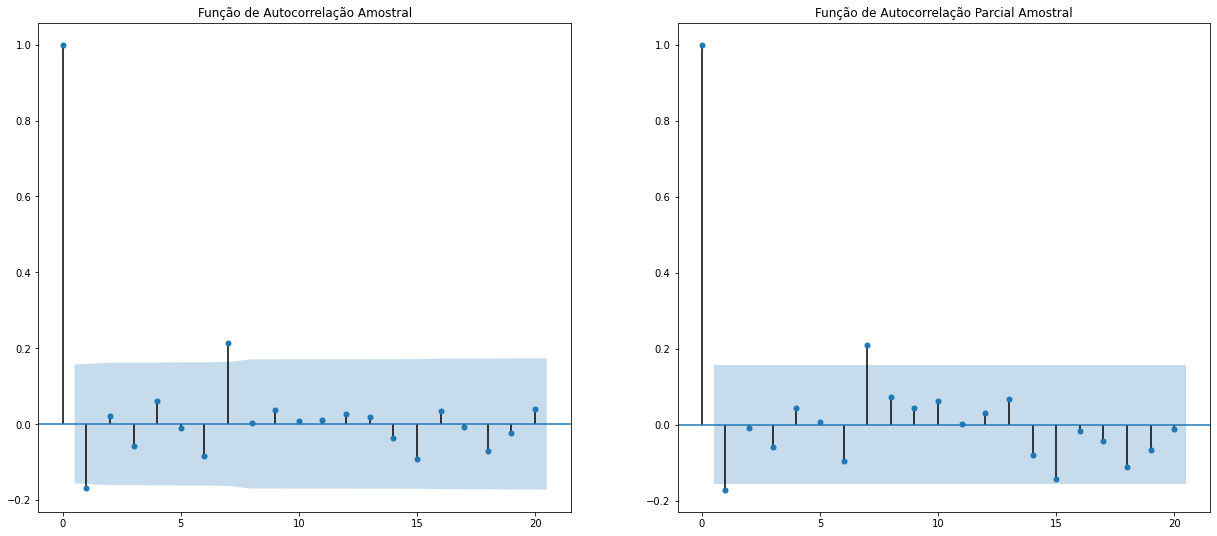

In [24]:
plt.figure(figsize = (21, 9))

ax1 = plt.subplot(1,2,1)
plot_acf(serie.dropna(), lags=20, title = 'Função de Autocorrelação Amostral', ax = ax1)

ax2 = plt.subplot(1,2,2)
plot_pacf(serie.dropna(), lags=20, title = 'Função de Autocorrelação Parcial Amostral', ax = ax2)



Logo, o modelo será ARIMA(1,2,1)

# Estimativa dos parâmetros

In [25]:
modelo1 = ARIMA(df_train['D-GLOBO'].dropna(), freq='D', order=(1,2,1)).fit()
print(modelo1.summary())

                             ARIMA Model Results                              
Dep. Variable:             D2.D-GLOBO   No. Observations:                  184
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -959.858
Method:                       css-mle   S.D. of innovations             43.929
Date:                Sun, 20 Jun 2021   AIC                           1927.717
Time:                        16:16:41   BIC                           1940.576
Sample:                    02-13-1998   HQIC                          1932.929
                         - 08-15-1998                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0228      0.052     -0.441      0.660      -0.124       0.079
ar.L1.D2.D-GLOBO    -0.1711      0.073     -2.347      0.020      -0.314      -0.028
ma.L1.D2.D-GLOBO    -1.0000 

In [26]:
 modelo1.params

const              -0.022838
ar.L1.D2.D-GLOBO   -0.171130
ma.L1.D2.D-GLOBO   -0.999952
dtype: float64

#Avaliação do modelo

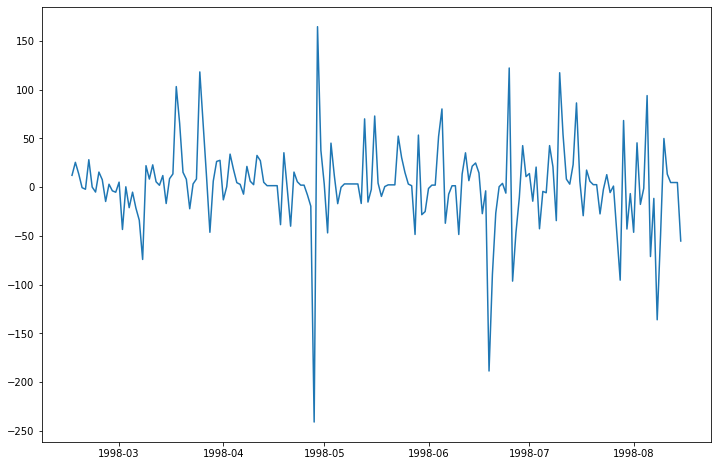

In [27]:
modelo1.resid

residuos = pd.DataFrame(modelo1.resid)
plt.figure(figsize = (12, 8))
plt.plot(residuos[2:])


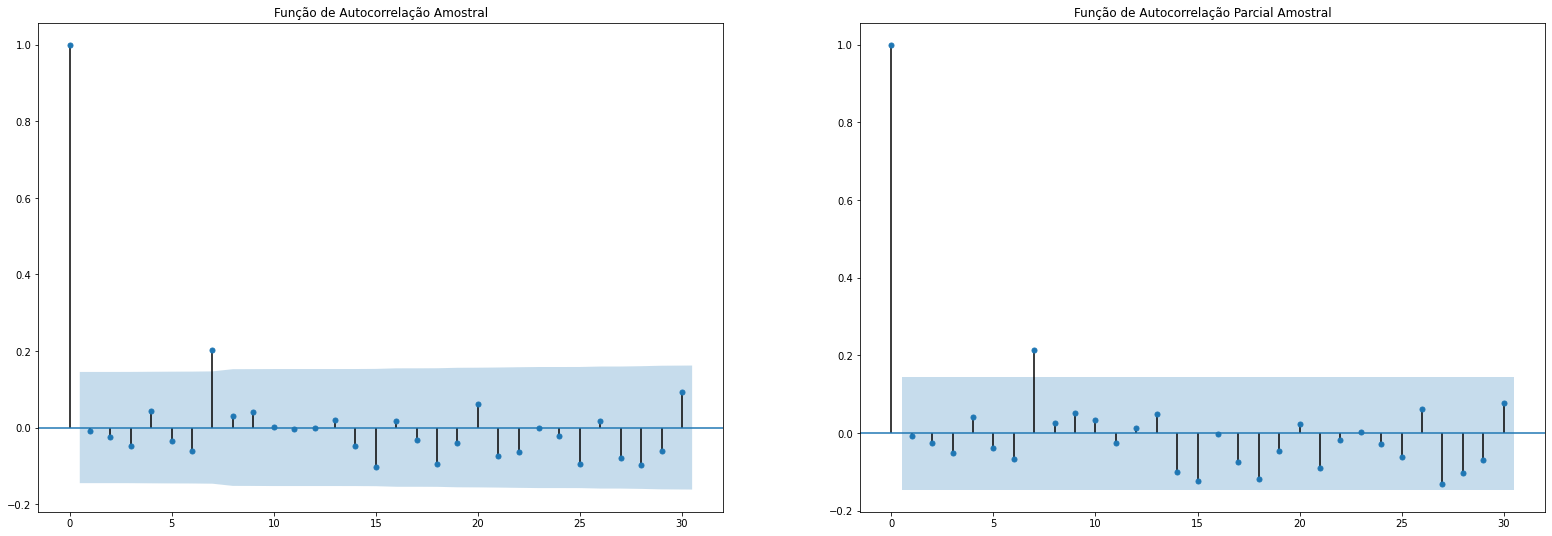

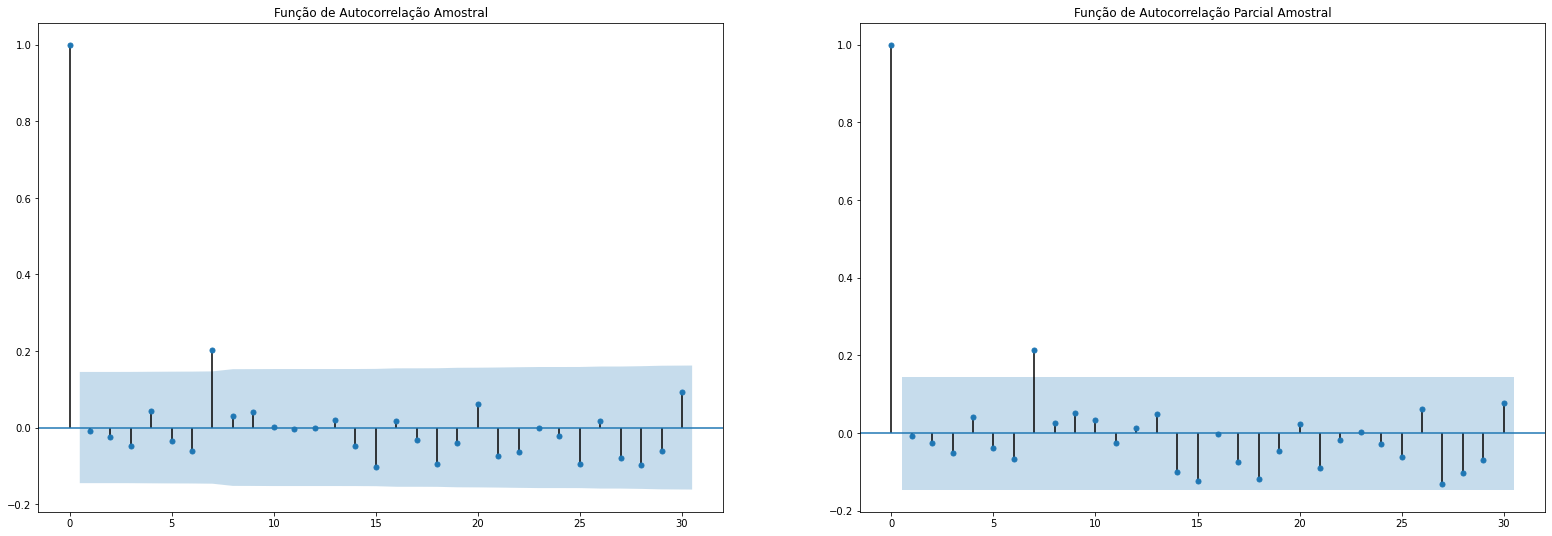

In [28]:
plt.figure(figsize = (27,9))

ax1 = plt.subplot(1,2,1)
plot_acf(residuos[2:], lags=30, title = 'Função de Autocorrelação Amostral', alpha = 0.05, ax = ax1)

ax3 = plt.subplot(1,2,2)
plot_pacf(residuos[2:], lags=30, title = 'Função de Autocorrelação Parcial Amostral', alpha = 0.05, ax = ax3)

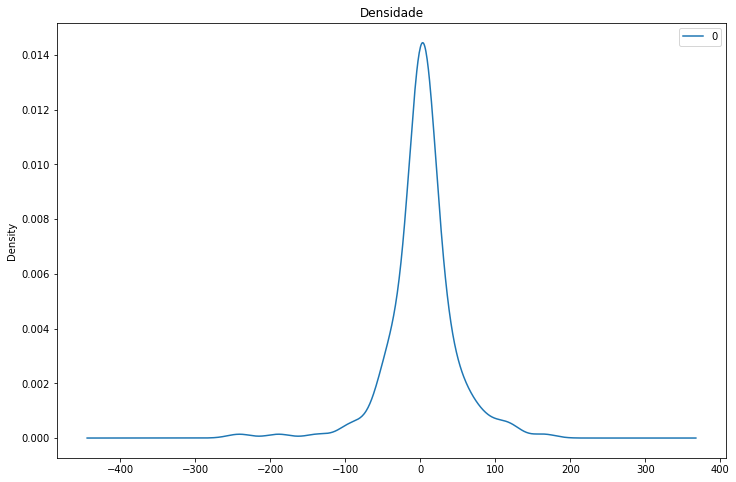

In [29]:
residuos.plot(figsize = (12,8), kind='kde')
plt.title('Densidade');

# Teste de modelo

In [30]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [31]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['D-GLOBO'].dropna(),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-263.8789990142914 foi o melhor valor de AIC

In [32]:
mod = sm.tsa.statespace.SARIMAX(data['D-GLOBO'].dropna(),
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0634      0.081     -0.781      0.435      -0.223       0.096
ma.S.L12      -1.0000    301.013     -0.003      0.997    -590.976     588.976
sigma2      2251.0924   6.78e+05      0.003      0.997   -1.33e+06    1.33e+06


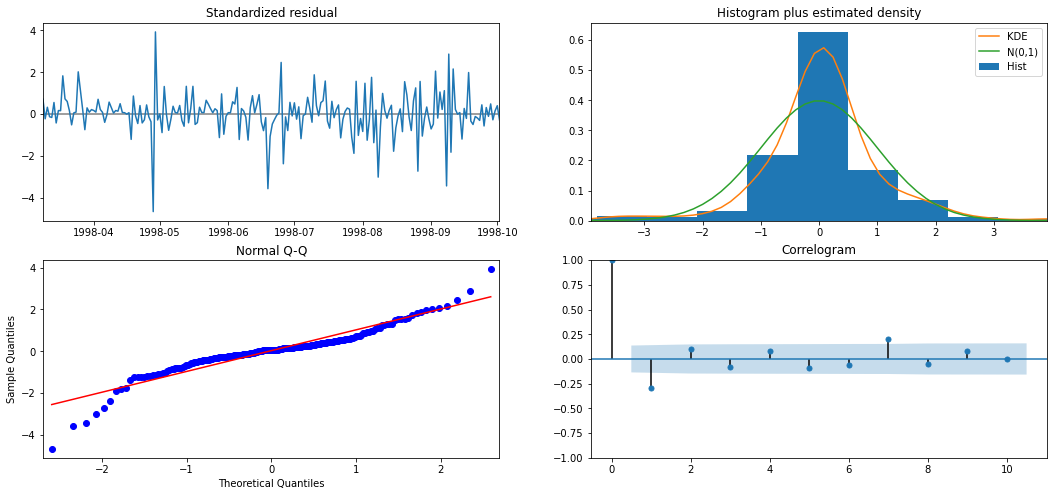

In [33]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

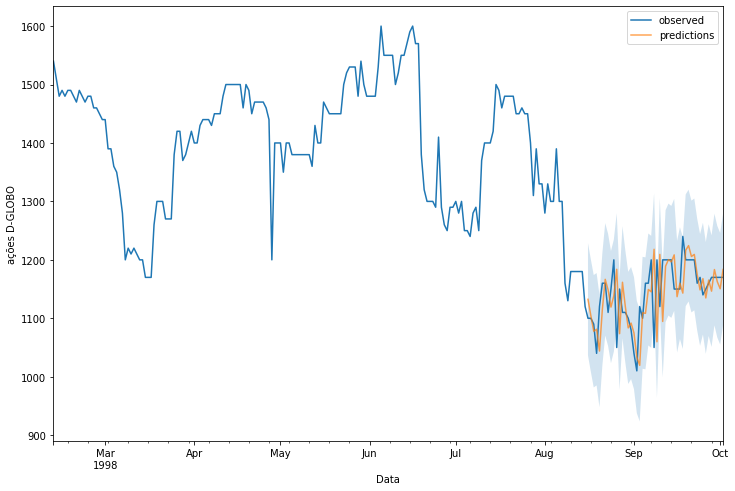

In [34]:
pred = results.get_prediction(start=pd.to_datetime('1998-08-16'), dynamic=False)
pred_ci = pred.conf_int()
ax = data['D-GLOBO'].dropna()['1998':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='predictions', alpha=.7, figsize=(12, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('ações D-GLOBO')
plt.legend()
plt.show()

In [43]:
y_forecasted = pred.predicted_mean
y_truth = df_test[comeco_test:termino_test]

from sklearn.metrics import mean_squared_error
mse = mean_absolute_error(y_truth, y_forecasted)
rmse = np.sqrt(mse)
print('a raíz quadrado do erro quadrático médio é {}'.format(rmse) )

o erro quadrático médio é 6.205596020955223


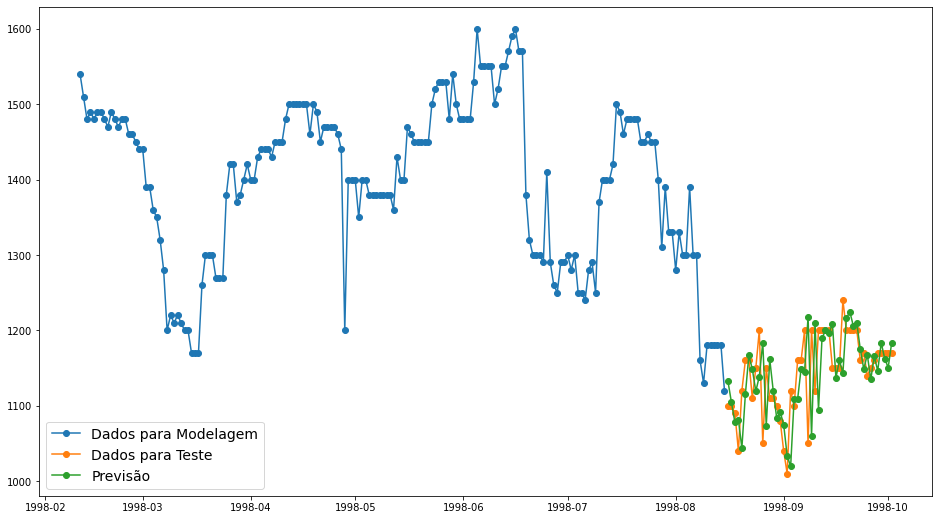

In [36]:
plt.figure(figsize = (16, 9))

plt.plot(df_train['D-GLOBO'], 'o-')
plt.plot(df_test['D-GLOBO'], 'o-')
plt.plot(y_forecasted, 'o-')

legenda = ('Dados para Modelagem', 'Dados para Teste', 'Previsão')
plt.legend(legenda, loc = 'lower left', prop = {'size': 14})

# Previsão

In [60]:
pred = results.forecast(steps=30)
pred


1998-10-03    1184.936601
1998-10-04    1188.639228
1998-10-05    1170.313275
1998-10-06    1159.367032
1998-10-07    1157.607053
1998-10-08    1152.598330
1998-10-09    1163.840530
1998-10-10    1150.820587
1998-10-11    1163.539318
1998-10-12    1162.206624
1998-10-13    1141.192656
1998-10-14    1154.031015
1998-10-15    1168.020190
1998-10-16    1171.487960
1998-10-17    1151.787224
1998-10-18    1142.169599
1998-10-19    1138.618359
1998-10-20    1134.561637
1998-10-21    1145.725044
1998-10-22    1134.165254
1998-10-23    1146.077237
1998-10-24    1144.829076
1998-10-25    1125.148021
1998-10-26    1137.172045
1998-10-27    1151.221315
1998-10-28    1154.703982
1998-10-29    1135.090448
1998-10-30    1125.388549
1998-10-31    1121.950928
1998-11-01    1117.833821
Freq: D, dtype: float64

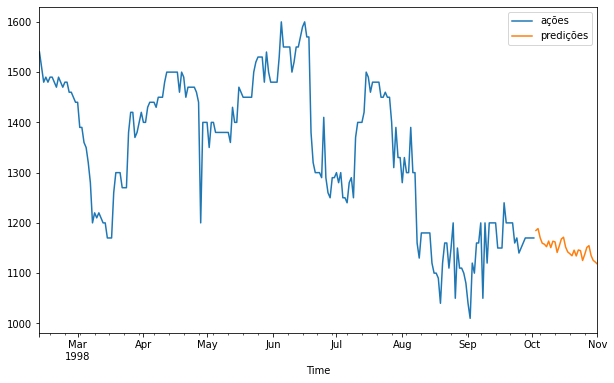

In [61]:
data['D-GLOBO'].plot(legend=True, label='ações', figsize=(10,6))
pred.plot(legend=True, label='predições')